<a href="https://colab.research.google.com/github/kameda-yoshinari/DataAlgo2020/blob/master/DataAlgo2020_009(%EF%BC%AE%E5%AF%BE%EF%BC%AE%E3%81%AE%E6%9C%80%E7%9F%AD%E7%B5%8C%E8%B7%AF%E5%95%8F%E9%A1%8C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.3. Ｎ対Ｎの最短経路問題

ここではグラフ中の任意の２頂点の間の最短経路問題とそれを解くFloydのアルゴリズムについて学ぶ．

**いつもの約束**  
１つのコードセルだけの実行は Ctrl + Enter．  
エディタで「インデント幅（スペース）は4で表示」「行番号を表示」「インデントガイドを表示」．  
挿入図は Google Colaboratory  以外では見れない可能性あり．  
内部では日本語はUTF-8で表現されている．


# 準備

インスタンスに接続し起動する．  
下記の手順でGoogle Driveをマウントする．  
マウント先に移動し，作業フォルダとする．  
これによって，インスタンスがリセットされてもGoogle Drive内にファイルが保存されるようにする．

In [0]:
!echo "Google Driveをマウントします"
from google.colab import drive 
drive.mount('/content/drive')

In [0]:
!echo "今回の作業用フォルダを作成しそこに移動します"
%cd /content/drive/My\ Drive/
%mkdir -p 202004_DataAlgo/DA2020_009
%cd       202004_DataAlgo/DA2020_009
!ls
!echo "日本時間表示"
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Japan /etc/localtime
!date

本節での説明には，4.2.節(Colab notebook 008)と同じくグラフ6を利用する．  
頂点数は8．無向グラフ．ループなし．重みは全て正．  
プログラムの解析用に，グラフ7, グラフ8も用意しておく．これらも4.2.節(Colab notebook 008)と同じ内容である．



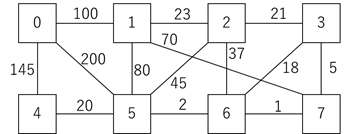

In [0]:
%%writefile graph6.h
// 8 nodes, undirected, no loop, positive weight.
// NC means no edges.
// NC will be treated as "inifinity" on searching the shortest path. 
#define N 8
#define NC 9999 // this big value means both no path and infinity 
int edge[N][N] = {
//     0   1   2   3   4   5   6   7
	{  0,100, NC, NC,145,200, NC, NC}, // 0
	{100,  0, 23, NC, NC, 80, NC, 70}, // 1
	{ NC, 23,  0, 21, NC, 45, 37, NC}, // 2
	{ NC, NC, 21,  0, NC, NC, 18,  5}, // 3
	{145, NC, NC, NC,  0, 20, NC, NC}, // 4
	{200, 80, 45, NC, 20,  0,  2, NC}, // 5
	{ NC, NC, 37, 18, NC,  2,  0,  1}, // 6
	{ NC, 70, NC,  5, NC, NC,  1,  0}  // 7
};

In [0]:
%%writefile graph7.h
// 4 nodes, directed, positive weight.
// NC means no edges.
// NC will be treated as "inifinity" on searching the shortest path. 
#define N 4
#define NC 9999 // this big value means no path
int edge[N][N] = {
//     0   1   2   3
	{  0, 10, NC, 40}, // 0
	{ NC,  0, NC, 20}, // 1
	{ NC, NC,  0, NC}, // 2
	{ NC, NC, NC,  0}, // 3
};

In [0]:
%%writefile graph8.h
// 12 nodes, directed, positive weight.
// NC means no edges.
// NC will be treated as "inifinity" on searching the shortest path. 
#define N 12
#define NC 9999 // this big value means no path
int edge[N][N] = {
    { 0, 4,NC,NC, 3,NC,NC,NC,NC,NC,NC,NC},
    { 4, 0, 1,NC,NC,NC, 2,NC,NC,NC,NC,NC},
    {NC, 1, 0, 1,NC,NC,NC, 2,NC,NC,NC,NC},
    {NC,NC, 1, 0,NC,NC,NC,NC,NC,NC,NC,NC},
    { 3,NC,NC,NC, 0, 1,NC,NC, 1,NC,NC,NC},
    {NC,NC,NC,NC, 1, 0, 2,NC,NC, 2, 3,NC},
    {NC, 2,NC,NC,NC, 2, 0,NC,NC,NC, 3,NC},
    {NC,NC, 2,NC,NC,NC,NC, 0,NC,NC,NC,NC},
    {NC,NC,NC,NC, 1,NC,NC,NC, 0,NC,NC,NC},
    {NC,NC,NC,NC,NC, 2,NC,NC,NC, 0,NC,NC},
    {NC,NC,NC,NC,NC, 3, 3,NC,NC,NC, 0, 1},
    {NC,NC,NC,NC,NC,NC,NC,NC,NC,NC, 1, 0}
};

# Ｎ対Ｎの最短経路問題を解くfloydのアルゴリズム

**内容**

グラフとして重み付き有向グラフを考える．辺に重みとして数値が付与されている．
本節では，辺の重みは正値とする．
隣接する頂点aと頂点bの間の辺の重みをedge(a,b)で表現する．edge(a,b)は正値である．  

最短経路問題とは，与えられた重み付き有向グラフにおいて，指定された２頂点間を結ぶ道を考える時，最も重みの軽い道の重みを求める問題である．ここでは，頂点Aから頂点Bへの「道」には，同じ頂点は高々一度しか現れないものとする．ある道（経路）が与えられた時，その辺の重みの合計のことを経路（道）の重み或いは経路値と呼ぶ．

指定された２頂点間に道がない場合は，その経路値は無限大として扱う．

解を示す道（経路）ももちろん求めるべきである．

**別解としてDijkstraのアルゴリズムの再利用**

新しいアルゴリズムを用意する前に，単純な方法を考えてみよう．
shortest_dijkstra プログラムを，開始頂点を1からNまで変えながら全て実行すれば解は得られるはずである．
この考え方は実に率直で，しかもオーダー表現による議論では，後で説明する floydのアルゴリズムとも変わらない．

ただ，floydのアルゴリズムは，これまたプログラミングスタイルとして（Diskstraのアルゴリズムと対極的に）劇的な例なので，本授業で取り上げて説明する．

**Floydのアルゴリズム**

Ｎ対Ｎの最短経路問題を解くアルゴリズムとして，Floyd（フロイド）のアルゴリズムを学習する．

Floydのアルゴリズムは，動的計画法(Dynamic programming)の１つとして知られる．

>**（動的計画法）**
>
>動的計画法の詳細は本授業では省くが，簡単に言えば，下記のようになる．
>
>1. 元の問題を分割する
>2. 分割した問題のそれぞれで解を求める
>3. それぞれの問題と解をペアにして覚えておく．
>4. 以降同じ問題が来たときは覚えておいた解を引用する（改めて解かない）
>5. 上記1-4を可能な限り繰り返す．つまり，元問題を分割して用意した部分問題を解く際に，さらに分割した部分部分問題を解く，とする．
>
>残念ながら，日常生活で動的計画法を使った処理をヒトが思いつくことはほぼない．これは，動的計画法の立案には緻密な問題検討と解法の設計が必要だからである．
>
>その代わり，がんばって動的計画法を立案できると，劇的なほどアルゴリズムが洗練され見通しがよくなり，多くの場合は実行時に様々な利点が得られることが多い．
>
>設計上の難点は，2.の分割を均等にしつつ，5.で再帰的に行えるようにできるか，である．

Floydのアルゴリズムにおいて，核となる部分は実は単純である．今，探索の途中にあるとし，頂点Aから頂点Bに至る（今までに見つかっている暫定最短）経路値を W(A,B) とする．
頂点A,B,Cについて， W(A,B) が W(A,C) + W(C,B) より小さい，つまり頂点Cを経由したほうが経路値が小さくなるのなら， W(A,B) の値を W(A,C) + W(C,B) の値で更新する．
これを繰り返すだけである．

問題は，これをいつどの順で行うのか，である．上手な順番を思いつかないと，いつまで経っても答えが得られなかったり，下手をすると堂々巡りするかもしれない．

Floydのアルゴリズムでは，これを，「段階的に経由してよい頂点を増やしていく」ことで実現する．この１段１段が部分問題に相当する．
さらに，部分問題の解を覚えるのに配列を用いるが，これを巧みに使うことで，解を覚えておくのに必要な領域を極限まで小さくかつ簡潔な表現にしている．

それでは実際のアルゴリズムを見てみよう．

0. 全ての頂点対A,Bについて，AからBへの暫定経路値 W(A,B) を無限大とする．
1. 全ての頂点対A,Bについて，隣接している（直行できる）場合のみ， W(A,B) = edge(A,B) と更新する．
2. 新たに経由してもいい頂点kを１つ選ぶ．(実装では k = 1,2,3, ..., N の順に選択）
3. 全ての頂点対A,Bについて，W(A,K) + W(K,B) < W(A,B) のときのみ W(A,B) = W(A,K) + W(K,B) と更新する．
4. 上記2.と3.を新たに経由してもいい頂点が無くなるまで繰り返す．

グラフ6による実行の様子を次図に示す．

ステップ1.が終わったところが「直通のみを認めた結果」である．
各要素はSrc頂点からDst頂点へ至る経路の暫定最小経路値 W(Src,Dst) が入っている．

次に，頂点0 を新たに経由頂点として認めることを考える．この時，

* W(Src,Dst)
* W(Src,0) + W(0, Dst)

という二つの暫定経路値を比較し，更新した場合は桃色で表示している．
このとき注意するべきなのは，頂点0から始発する経路と，頂点0に終着する経路は，その暫定最小経路値が変わるはずがないという事実である．つまり，図において，太枠で囲まれた部分は，値の更新が絶対に発生しない．

> 仙台と名古屋の間の出張を安く行くように考えている時，それまで直通出張しか許されなかったのが「東京も経由していいよ」と言われれば検討するが，「仙台を経由してもいいよ」と言われても「何意味のないことを言ってるの？」となろう（山形から盛岡に出張を考えている者には意味のある言葉なのだが）．

かつ，暫定経路値の２つめの和のほうは，その変わるはずのない経路**のみ**を組み合わせて算出している点にも注意する．次図中では， W(1,4) はそれまで NC であったが， 100+145=245 という新しい値で更新している．このような暫定経路値の吟味と更新を，N*Nのどのセルをどの順で更新しても，この結果が他のセルの実行結果で影響を受けることはない．（その意味でN*Nのセルの更新はN*N並列で実行可能）

あとは，これを繰り返していく．次の「頂点1を経由頂点として追加した結果」では，その前提となる暫定経路値は W(Src,1) と　W(1,Dst) である．このどちらも「直行ないし頂点0の経由迄が認められたうちでの最小経路値」が示されていることに注意する．

説明しても納得には時間がかかるかもしれない．図を丁寧に追いかけて理解することを望む．ほぼ同等の結果を次のプログラムで表示できるようにしてあるので，グラフを変えてみたりしながら理解して頂きたい．  
これが理解できた瞬間に，どうして動的計画法を普段なかなか人間は思いついて実行したりしないかを実感できることであろう．

**実装**

プログラミングに当たっては難しいところはない．  


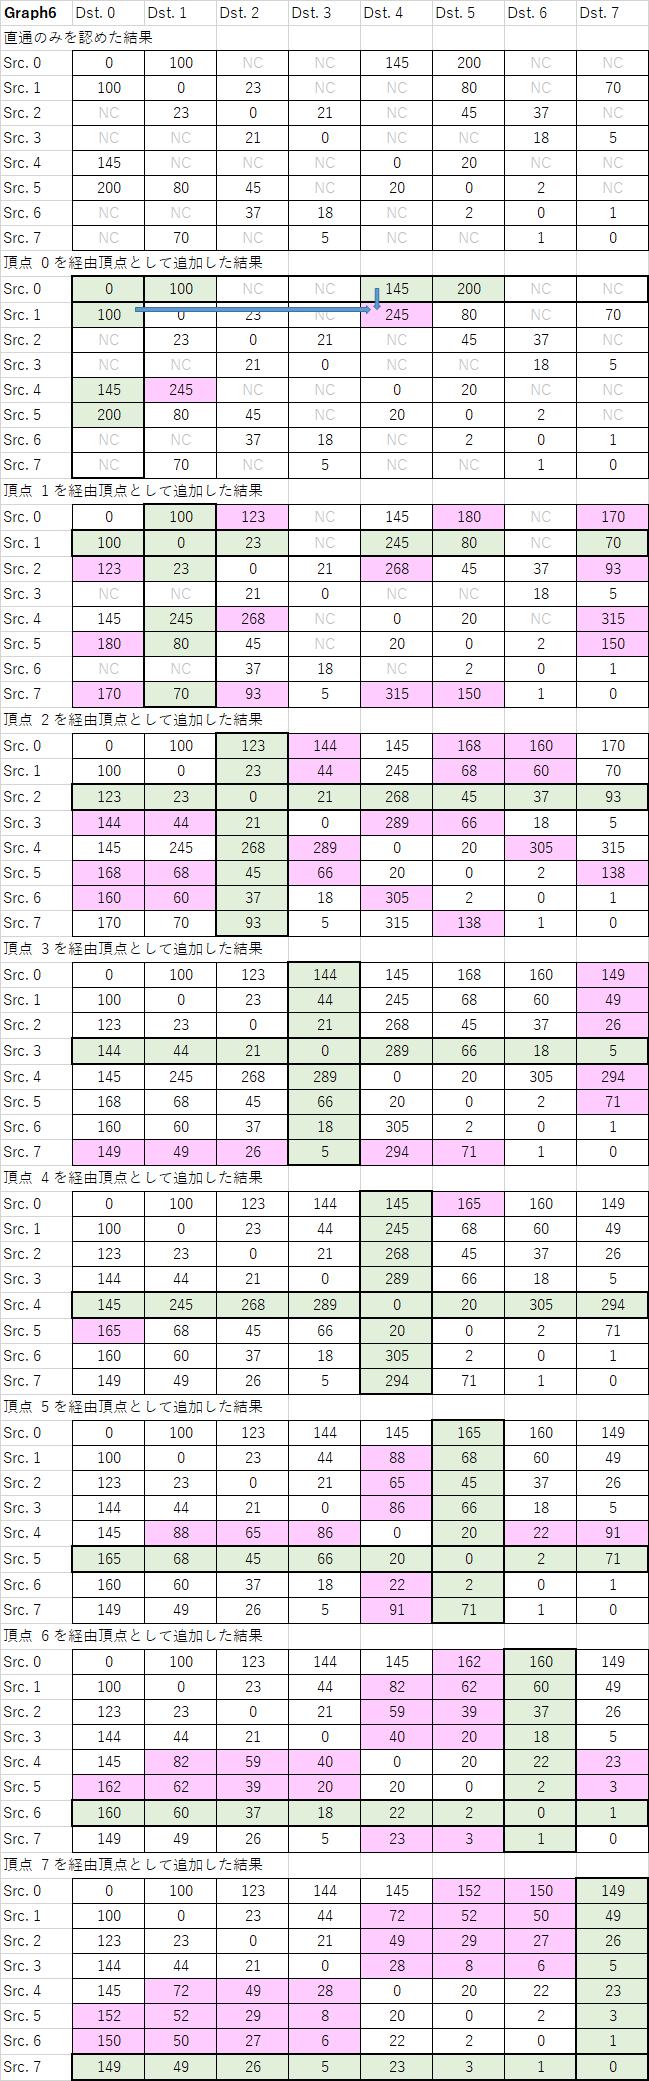

# Flyodのアルゴリズムに基づくプログラム

**目標**

正値重みの辺で構成される有向グラフにおいて，グラフ上の任意の頂点対の最小経路値とその経路を求めるＣプログラムを作成する．

**説明**

Floydのアルゴリズム本体は一つのユーザ定義関数 find_shortest_floyd() で実装する．

**コード**

C言語では無限大という数は扱えない．それに関連する演算「無限大 + 定数 = 無限大」も扱えない．
ここでは，無限大の代わりに十分大きな数（より正確には処理の途中で一時的に得られるであろう暫定経路値の最大値より大きい数）NCを用意し，NCに辺の最大重みを加えてもまだC言語の演算範囲内にあるものとして実装を行う．

なお，なにかしら引数を１つ指定すると，上述の解説図と同じような出力が得られるようにしてある．(verboselevel変数に注意してコードを読むこと）


**備考**

最短経路を実際に求めている部分は本当に解いているのか？と疑いたくなるぐらい短いプログラムである．理解のためにコメント行と表示用コードを差し込んでいるが，試しにそれらを削除してみるとその短さが実感できるであろう．３重ループの内側にif文が1つあるだけなのである．

In [0]:
%%writefile shortest-floyd_J.c
// Shortest path by Floyd
//    2020/06/07 kameda
#include <stdio.h> // printf()
#include <stdlib.h> // atoi()
#include "graph6.h" // edge[][], N, NC

int verboselevel = 0; // 表示レベル 0：通常，1:説明用（アルゴリズムの説明参照）

typedef struct {
	int cost; // 暫定経路値（暫定最小値）
	int via; // 経由頂点
} CostVia;

CostVia pathinfo[N][N]; // 	[a][b] 開始頂点a, 到着頂点b

// 全経路の表示（再帰呼出を利用）
// この方法だと最終到着頂点は表示されないので注意
void outputpath(int SrcNode, int DstNode){
	// 再帰呼び出しの終了条件は「直行便」 (via[s][d]==s)。出発側のみ表示
	if (SrcNode == pathinfo[SrcNode][DstNode].via) {
		printf("%2d ", SrcNode);
	} else {
		// 経由地の前後のPATHそれぞれ探索して表示
		outputpath(SrcNode, pathinfo[SrcNode][DstNode].via);
		outputpath(pathinfo[SrcNode][DstNode].via, DstNode);
	}
}

// 経由行列の表示
void print_path_status(void){
	int SrcNode, DstNode;

	if (verboselevel == 0) {
		for (SrcNode = 0; SrcNode < N; SrcNode++) {
			for (DstNode = 0; DstNode < N; DstNode++) {
				if (pathinfo[SrcNode][DstNode].cost >= NC) 
					printf("---(--) ");
				else
					printf("%3d(%2d) ", pathinfo[SrcNode][DstNode].cost, pathinfo[SrcNode][DstNode].via);
			}
			printf("\n");
		}
	} else {
		for (SrcNode = 0; SrcNode < N; SrcNode++) {
			for (DstNode = 0; DstNode < N; DstNode++) {
				if (pathinfo[SrcNode][DstNode].cost >= NC) 
					printf("NC\t");
				else
					printf("%d\t", pathinfo[SrcNode][DstNode].cost);
				}
			printf("\n");
		}
	}

	return ;
}

void find_shortest_floyd(void){
	int SrcNode, DstNode;
	int MidNode; // a.k.a. "k"
	int NewCost;
	
	// 直行のみを認める形で初期化
	// 直行できない頂点対の場合はNC（＝直交で行けない）という重みで初期化
	for (SrcNode = 0; SrcNode < N; SrcNode++) {
		for (DstNode = 0; DstNode < N; DstNode++) {
			pathinfo[SrcNode][DstNode].cost = edge[SrcNode][DstNode];
			pathinfo[SrcNode][DstNode].via  = SrcNode; // 直行が解の時は via == SrcNode
		}
	}
	printf("直通のみを認めた結果 ===\n");
	print_path_status();

	// 中継に使ってよい頂点(MidNode)を１つずつ増やしていく
	// 新しい中継頂点(MidNode)が使えるようになったら，各頂点間で「その１」「その２」のどちらが最小コストか検討
	// その１: MidNodeを無視して（それより前に認められていた頂点群のみを用いて）到達
	// その２: MidNodeを経由して到達
	//    ※ここで、SrcNode=>MidNodeの最小コストは前段(MidNodeを用いない時点)で確定していることに注意
	//    ※これはMidNode=>DstNodeでも同じ
	//    理由：重みは全て正値なので、MidNodeが経路の端に現れているときに同じMidNodeを中継頂点にしても最小コストになるはずがない
	// 「その２」のほうがコスト小の場合，コスト更新，かつ経由頂点をMidNodeで更新
	for (MidNode = 0; MidNode < N; MidNode++) {
		for (SrcNode = 0; SrcNode < N; SrcNode++) {
			for (DstNode = 0; DstNode < N; DstNode++) {
				NewCost = pathinfo[SrcNode][MidNode].cost + pathinfo[MidNode][DstNode].cost;
				if (NewCost < pathinfo[SrcNode][DstNode].cost) {
					pathinfo[SrcNode][DstNode].cost = NewCost;
					pathinfo[SrcNode][DstNode].via  = MidNode;
				}
			}
		}
		printf("頂点 %2d を経由頂点として追加した結果 ===\n", MidNode);
		print_path_status();
	}

	// 結果の表示
	if (verboselevel == 0) {
		printf("最短経路問題の答\n");
		for (SrcNode = 0; SrcNode < N; SrcNode++) {
			for (DstNode = 0; DstNode < N; DstNode++) {
				printf("%2d => %2d: ",SrcNode, DstNode);
				if (pathinfo[SrcNode][DstNode].cost == NC) {
					printf("  - : (No path)");
				} else {
					printf("%3d :", pathinfo[SrcNode][DstNode].cost);
					outputpath(SrcNode, DstNode);
					printf("%2d", DstNode);
				}
				printf("\n");
			}

			printf("\n");
		}
	}

	return ;
}

int main(int argc, char *argv[]){
	  
    if (argc >= 2) {
		verboselevel = 1;
		printf("結果を暫定経路値のみで表示します．\n");
	}

	find_shortest_floyd();

	return 0;
}



コンパイルしてエラーが無いことを確認．

In [0]:
!gcc -Wall -o shortest-floyd_J shortest-floyd_J.c

実行．
コマンドライン引数をなにか付けると，途中の表示がシンプルになる．

In [0]:
!echo "シンプル版（途中結果で算定経路値のみ表示）"
!./shortest-floyd_J 0
!echo "通常版（途中結果で経由頂点も表示）"
!./shortest-floyd_J

# 節末課題

1. 最短経路の表示の仕組み  
shortest_floyd Cプログラムにおいて，全ての頂点対の最小経路を表示する部分には再帰呼出関数を用いている．これについて，本プログラムが最小経路を表示している仕組みを説明せよ．特に，via[][]が格納している値について言及しながら説明すること．（参考：去年まではこの部分を自ら作成するのが課題であった．今年から読むだけにしたので，随分簡単な課題にしたものである）


2. 計算量  
shortest_floyd プログラムの時間計算量と空間計算量を議論せよ．


3. 十分大きな数NC  
あるグラフが与えられた時，暫定経路値の一時的最大値と最大重み辺が分かれば，NCを決めることができる．これを正確に求めることは難しいが，アルゴリズムの趣旨を考えれば，これは正確な値である必要はない．そこで，グラフの隣接行列が与えられたとして，NCの近似値として役に立つ数字を 時間計算量 O(N^2) で求める簡単な方法を考えてみよ．


4. shortest_diskstra プログラムの再利用  
N対Nの最短経路問題を解くにあたって，shortest_diskstra プログラムを改良して実現して見よ．プログラム内で開始頂点を1からNまで変更しながら，dijkstraのアルゴリズムを実行するという方針である．改良したプログラムについて，時間計算量と空間計算量を議論せよ．

# 出典

筑波大学工学システム学類  
データ構造とアルゴリズム  
担当：亀田能成  
2020/06/07.


